# How To Build An Agentic Chatbot With Claude 3.5 Sonnet, LangGraph and MongoDB


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/hr_agentic_chatbot_with_langgraph_claude.ipynb)

## Install Libraries

In [1]:
!pip install -U --quiet langgraph langchain-community langchain-anthropic langchain-openai langchain-mongodb langsmith
!pip install -U --quiet pandas openai pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 837.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

## Set Environment Variables

In [2]:
import os

os.environ["OPENAI_API_KEY"] = ""
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

os.environ["ANTHROPIC_API_KEY"] = ""
ANTHROPIC_API_KEY = os.environ.get("ANTHROPIC_API_KEY")

OPEN_AI_EMBEDDING_MODEL="text-embedding-3-small"
OPEN_AI_EMBEDDING_MODEL_DIMENSION=256

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=""
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]="hr_agentic_chatbot"

## Synthetic Data Generation

In [3]:
import pandas as pd
import random
import json


# Define a list of job titles and departments for variety
job_titles = [
    "Software Engineer", "Senior Software Engineer", "Data Scientist", "Product Manager",
    "Project Manager", "UX Designer", "QA Engineer", "DevOps Engineer", "CTO", "CEO"
]
departments = [
    "IT", "Engineering", "Data Science", "Product", "Project Management", "Design",
    "Quality Assurance", "Operations", "Executive"
]

# Define a list of office locations
office_locations = [
    "Chicago Office", "New York Office", "London Office", "Berlin Office", "Tokyo Office",
    "Sydney Office", "Toronto Office", "San Francisco Office", "Paris Office", "Singapore Office"
]

# Define a function to create a random employee entry
def create_employee(employee_id, first_name, last_name, job_title, department, manager_id=None):
    return {
        "employee_id": employee_id,
        "first_name": first_name,
        "last_name": last_name,
        "gender": random.choice(["Male", "Female"]),
        "date_of_birth": f"{random.randint(1950, 2000)}-{random.randint(1, 12):02}-{random.randint(1, 28):02}",
        "address": {
            "street": f"{random.randint(100, 999)} Main Street",
            "city": "Springfield",
            "state": "IL",
            "postal_code": "62704",
            "country": "USA"
        },
        "contact_details": {
            "email": f"{first_name.lower()}.{last_name.lower()}@example.com",
            "phone_number": f"+1-555-{random.randint(100, 999)}-{random.randint(1000, 9999)}"
        },
        "job_details": {
            "job_title": job_title,
            "department": department,
            "hire_date": f"{random.randint(2000, 2022)}-{random.randint(1, 12):02}-{random.randint(1, 28):02}",
            "employment_type": "Full-Time",
            "salary": random.randint(50000, 250000),
            "currency": "USD"
        },
        "work_location": {
            "nearest_office": random.choice(office_locations),
            "is_remote": random.choice([True, False])
        },
        "reporting_manager": manager_id,
        "skills": random.sample(
            ["JavaScript", "Python", "Node.js", "React", "Django", "Flask", "AWS", "Docker", "Kubernetes", "SQL"], 4
        ),
        "performance_reviews": [
            {
                "review_date": f"{random.randint(2020, 2023)}-{random.randint(1, 12):02}-{random.randint(1, 28):02}",
                "rating": round(random.uniform(3, 5), 1),
                "comments": random.choice([
                    "Exceeded expectations in the last project.",
                    "Consistently meets performance standards.",
                    "Needs improvement in time management.",
                    "Outstanding performance and dedication."
                ])
            },
            {
                "review_date": f"{random.randint(2019, 2022)}-{random.randint(1, 12):02}-{random.randint(1, 28):02}",
                "rating": round(random.uniform(3, 5), 1),
                "comments": random.choice([
                    "Exceeded expectations in the last project.",
                    "Consistently meets performance standards.",
                    "Needs improvement in time management.",
                    "Outstanding performance and dedication."
                ])
            }
        ],
        "benefits": {
            "health_insurance": random.choice(["Gold Plan", "Silver Plan", "Bronze Plan"]),
            "retirement_plan": "401K",
            "paid_time_off": random.randint(15, 30)
        },
        "emergency_contact": {
            "name": f"{random.choice(['Jane', 'Emily', 'Michael', 'Robert'])} {random.choice(['Doe', 'Smith', 'Johnson'])}",
            "relationship": random.choice(["Spouse", "Parent", "Sibling", "Friend"]),
            "phone_number": f"+1-555-{random.randint(100, 999)}-{random.randint(1000, 9999)}"
        },
        "notes": random.choice([
            "Promoted to Senior Software Engineer in 2020.",
            "Completed leadership training in 2021.",
            "Received Employee of the Month award in 2022.",
            "Actively involved in company hackathons and innovation challenges."
        ])
    }

# Generate 10 employee entries
employees = [
    create_employee("E123456", "John", "Doe", "Software Engineer", "IT", "M987654"),
    create_employee("E123457", "Jane", "Doe", "Senior Software Engineer", "IT", "M987654"),
    create_employee("E123458", "Emily", "Smith", "Data Scientist", "Data Science", "M987655"),
    create_employee("E123459", "Michael", "Brown", "Product Manager", "Product", "M987656"),
    create_employee("E123460", "Sarah", "Davis", "Project Manager", "Project Management", "M987657"),
    create_employee("E123461", "Robert", "Johnson", "UX Designer", "Design", "M987658"),
    create_employee("E123462", "David", "Wilson", "QA Engineer", "Quality Assurance", "M987659"),
    create_employee("E123463", "Chris", "Lee", "DevOps Engineer", "Operations", "M987660"),
    create_employee("E123464", "Sophia", "Garcia", "CTO", "Executive", None),
    create_employee("E123465", "Olivia", "Martinez", "CEO", "Executive", None)
]

In [4]:
# Convert to DataFrame
df_employees = pd.DataFrame(employees)

# Save DataFrame to CSV
csv_file_employees = 'synthetic_data_employees.csv'
df_employees.to_csv(csv_file_employees, index=False)

print(f"Synthetic employee data has been saved to {csv_file_employees}")

Synthetic employee data has been saved to synthetic_data_employees.csv


In [5]:
df_employees.head()

,employee_id,first_name,last_name,gender,date_of_birth,address,contact_details,job_details,work_location,reporting_manager,skills,performance_reviews,benefits,emergency_contact,notes
0,E123456,John,Doe,Male,1988-01-17,"{'street': '637 Main Street', 'city': 'Springf...","{'email': 'john.doe@example.com', 'phone_numbe...","{'job_title': 'Software Engineer', 'department...","{'nearest_office': 'Paris Office', 'is_remote'...",M987654,"[Flask, AWS, Kubernetes, JavaScript]","[{'review_date': '2020-12-26', 'rating': 4.2, ...","{'health_insurance': 'Gold Plan', 'retirement_...","{'name': 'Jane Smith', 'relationship': 'Spouse...",Completed leadership training in 2021.
1,E123457,Jane,Doe,Male,1975-02-11,"{'street': '776 Main Street', 'city': 'Springf...","{'email': 'jane.doe@example.com', 'phone_numbe...","{'job_title': 'Senior Software Engineer', 'dep...","{'nearest_office': 'Berlin Office', 'is_remote...",M987654,"[AWS, Django, React, Python]","[{'review_date': '2021-09-23', 'rating': 3.4, ...","{'health_insurance': 'Silver Plan', 'retiremen...","{'name': 'Emily Doe', 'relationship': 'Spouse'...",Received Employee of the Month award in 2022.
2,E123458,Emily,Smith,Male,1996-04-26,"{'street': '613 Main Street', 'city': 'Springf...","{'email': 'emily.smith@example.com', 'phone_nu...","{'job_title': 'Data Scientist', 'department': ...","{'nearest_office': 'Paris Office', 'is_remote'...",M987655,"[Flask, AWS, Kubernetes, Python]","[{'review_date': '2021-08-27', 'rating': 4.3, ...","{'health_insurance': 'Gold Plan', 'retirement_...","{'name': 'Robert Smith', 'relationship': 'Sibl...",Promoted to Senior Software Engineer in 2020.
3,E123459,Michael,Brown,Female,1975-09-03,"{'street': '887 Main Street', 'city': 'Springf...","{'email': 'michael.brown@example.com', 'phone_...","{'job_title': 'Product Manager', 'department':...","{'nearest_office': 'Sydney Office', 'is_remote...",M987656,"[Kubernetes, SQL, React, Python]","[{'review_date': '2021-03-16', 'rating': 3.7, ...","{'health_insurance': 'Gold Plan', 'retirement_...","{'name': 'Emily Johnson', 'relationship': 'Sib...",Promoted to Senior Software Engineer in 2020.
4,E123460,Sarah,Davis,Female,1999-02-08,"{'street': '468 Main Street', 'city': 'Springf...","{'email': 'sarah.davis@example.com', 'phone_nu...","{'job_title': 'Project Manager', 'department':...","{'nearest_office': 'Toronto Office', 'is_remot...",M987657,"[AWS, Kubernetes, Node.js, SQL]","[{'review_date': '2022-06-01', 'rating': 3.1, ...","{'health_insurance': 'Silver Plan', 'retiremen...","{'name': 'Emily Doe', 'relationship': 'Friend'...",Completed leadership training in 2021.


## Embedding Generation

In [6]:
# Function to create a string representation of the employee's key attributes for embedding
def create_employee_string(employee):
    job_details = f"{employee['job_details']['job_title']} in {employee['job_details']['department']}"
    skills = ", ".join(employee['skills'])
    performance_reviews = " ".join([f"Rated {review['rating']} on {review['review_date']}: {review['comments']}" for review in employee['performance_reviews']])
    basic_info = f"{employee['first_name']} {employee['last_name']}, {employee['gender']}, born on {employee['date_of_birth']}"
    work_location = f"Works at {employee['work_location']['nearest_office']}, Remote: {employee['work_location']['is_remote']}"
    notes = employee['notes']

    return f"{basic_info}. Job: {job_details}. Skills: {skills}. Reviews: {performance_reviews}. Location: {work_location}. Notes: {notes}"

# Example usage with one employee
employee_string = create_employee_string(employees[0])
print(f"Here's what an employee string looks like: /n {employee_string}")

Here's what an employee string looks like: /n John Doe, Male, born on 1988-01-17. Job: Software Engineer in IT. Skills: Flask, AWS, Kubernetes, JavaScript. Reviews: Rated 4.2 on 2020-12-26: Outstanding performance and dedication. Rated 3.8 on 2020-03-09: Consistently meets performance standards.. Location: Works at Paris Office, Remote: False. Notes: Completed leadership training in 2021.


In [7]:
# Apply the function to all employees
df_employees['employee_string'] = df_employees.apply(create_employee_string, axis=1)

In [8]:
from tqdm import tqdm
import openai

# Generate an embedding using OpenAI's API
def get_embedding(text):
    """Generate an embedding for the given text using OpenAI's API."""

    # Check for valid input
    if not text or not isinstance(text, str):
        return None

    try:
        # Call OpenAI API to get the embedding
        embedding = openai.embeddings.create(
            input=text,
            model=OPEN_AI_EMBEDDING_MODEL, dimensions=OPEN_AI_EMBEDDING_MODEL_DIMENSION).data[0].embedding
        return embedding
    except Exception as e:
        print(f"Error in get_embedding: {e}")
        return None

# Apply the function to generate embeddings for all employees with error handling and progress tracking
try:
    df_employees['embedding'] = [x for x in tqdm(df_employees['employee_string'].apply(get_embedding), total=len(df_employees))]
    print("Embeddings generated for employees")
except Exception as e:
    print(f"Error applying embedding function to DataFrame: {e}")

100%|██████████| 10/10 [00:00<00:00, 33261.73it/s]

Embeddings generated for employees


In [9]:
# Observe the new 'embedding' coloumn
df_employees.head()

,employee_id,first_name,last_name,gender,date_of_birth,address,contact_details,job_details,work_location,reporting_manager,skills,performance_reviews,benefits,emergency_contact,notes,employee_string,embedding
0,E123456,John,Doe,Male,1988-01-17,"{'street': '637 Main Street', 'city': 'Springf...","{'email': 'john.doe@example.com', 'phone_numbe...","{'job_title': 'Software Engineer', 'department...","{'nearest_office': 'Paris Office', 'is_remote'...",M987654,"[Flask, AWS, Kubernetes, JavaScript]","[{'review_date': '2020-12-26', 'rating': 4.2, ...","{'health_insurance': 'Gold Plan', 'retirement_...","{'name': 'Jane Smith', 'relationship': 'Spouse...",Completed leadership training in 2021.,"John Doe, Male, born on 1988-01-17. Job: Softw...","[-0.0711723044514656, 0.04006121680140495, 0.0..."
1,E123457,Jane,Doe,Male,1975-02-11,"{'street': '776 Main Street', 'city': 'Springf...","{'email': 'jane.doe@example.com', 'phone_numbe...","{'job_title': 'Senior Software Engineer', 'dep...","{'nearest_office': 'Berlin Office', 'is_remote...",M987654,"[AWS, Django, React, Python]","[{'review_date': '2021-09-23', 'rating': 3.4, ...","{'health_insurance': 'Silver Plan', 'retiremen...","{'name': 'Emily Doe', 'relationship': 'Spouse'...",Received Employee of the Month award in 2022.,"Jane Doe, Male, born on 1975-02-11. Job: Senio...","[-0.017159942537546158, 0.04259845241904259, 0..."
2,E123458,Emily,Smith,Male,1996-04-26,"{'street': '613 Main Street', 'city': 'Springf...","{'email': 'emily.smith@example.com', 'phone_nu...","{'job_title': 'Data Scientist', 'department': ...","{'nearest_office': 'Paris Office', 'is_remote'...",M987655,"[Flask, AWS, Kubernetes, Python]","[{'review_date': '2021-08-27', 'rating': 4.3, ...","{'health_insurance': 'Gold Plan', 'retirement_...","{'name': 'Robert Smith', 'relationship': 'Sibl...",Promoted to Senior Software Engineer in 2020.,"Emily Smith, Male, born on 1996-04-26. Job: Da...","[0.003667315933853388, 0.029469972476363182, 0..."
3,E123459,Michael,Brown,Female,1975-09-03,"{'street': '887 Main Street', 'city': 'Springf...","{'email': 'michael.brown@example.com', 'phone_...","{'job_title': 'Product Manager', 'department':...","{'nearest_office': 'Sydney Office', 'is_remote...",M987656,"[Kubernetes, SQL, React, Python]","[{'review_date': '2021-03-16', 'rating': 3.7, ...","{'health_insurance': 'Gold Plan', 'retirement_...","{'name': 'Emily Johnson', 'relationship': 'Sib...",Promoted to Senior Software Engineer in 2020.,"Michael Brown, Female, born on 1975-09-03. Job...","[-0.0264598298817873, 0.030107785016298294, 0...."
4,E123460,Sarah,Davis,Female,1999-02-08,"{'street': '468 Main Street', 'city': 'Springf...","{'email': 'sarah.davis@example.com', 'phone_nu...","{'job_title': 'Project Manager', 'department':...","{'nearest_office': 'Toronto Office', 'is_remot...",M987657,"[AWS, Kubernetes, Node.js, SQL]","[{'review_date': '2022-06-01', 'rating': 3.1, ...","{'health_insurance': 'Silver Plan', 'retiremen...","{'name': 'Emily Doe', 'relationship': 'Friend'...",Completed leadership training in 2021.,"Sarah Davis, Female, born on 1999-02-08. Job: ...","[0.011142105795443058, 0.020625432953238487, 0..."


## MongoDB Database Setup


**Steps to creating a MongoDB Database**
- [Register for a free MongoDB Atlas Account](https://www.mongodb.com/cloud/atlas/register?utm_campaign=devrel&utm_source=workshop&utm_medium=organic_social&utm_content=rag%20to%20agents%20notebook&utm_term=richmond.alake)
- [Create a Cluster](https://www.mongodb.com/docs/guides/atlas/cluster/)
- [Get your connection string](https://www.mongodb.com/docs/guides/atlas/connection-string/)





In [10]:
os.environ["MONGO_URI"] = ""

MONGO_URI = os.environ.get("MONGO_URI")

In [11]:
from pymongo.mongo_client import MongoClient

DATABASE_NAME = "demo_company_employees"
COLLECTION_NAME = "employees_records"

def get_mongo_client(mongo_uri):
    """Establish connection to the MongoDB and ping the database."""

    # gateway to interacting with a MongoDB database cluster
    client = MongoClient(mongo_uri, appname="devrel.showcase.hr_agent.python")

    # Ping the database to ensure the connection is successful
    try:
        client.admin.command('ping')
        print("Connection to MongoDB successful")
    except Exception as e:
        print(f"Error connecting to MongoDB: {e}")
        return None

    return client

if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(MONGO_URI)

if mongo_client:
    # Pymongo client of database and collection
    db = mongo_client.get_database(DATABASE_NAME)
    collection = db.get_collection(COLLECTION_NAME)
else:
    print("Failed to connect to MongoDB. Exiting...")
    exit(1)

Connection to MongoDB successful


## Data Ingestion

In [12]:
# Clean up collection of exisiting record
collection.delete_many({})

DeleteResult({'n': 10, 'electionId': ObjectId('7fffffff000000000000002a'), 'opTime': {'ts': Timestamp(1720096850, 10), 't': 42}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1720096850, 10), 'signature': {'hash': b'DG\xd3GP)\xfd\xb5\xe5\x9a\x1e\xcfG\x82\xff\xbes\xfb\xa4A', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1720096850, 10)}, acknowledged=True)

In [13]:
documents = df_employees.to_dict('records')

# Ingest data into MongoDB Database
collection.insert_many(documents)
print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Vector Search Index Initalisation

1.4 Vector Index Creation

- [Create an Atlas Vector Search Index](https://www.mongodb.com/docs/compass/current/indexes/create-vector-search-index/)

- If you are following this notebook ensure that you are creating a vector search index for the right database(demo_company_employees) and collection(employees_records)

Below is the vector search index definition for this notebook

```json
{
  "fields": [
    {
      "numDimensions": 256,
      "path": "embedding",
      "similarity": "cosine",
      "type": "vector"
    }
  ]
}
```

- Give your vector search index the name "vector_index" if you are following this notebook


## Agentic System Memory

In [14]:
from langchain_mongodb.chat_message_histories import MongoDBChatMessageHistory
from langchain.memory import ConversationBufferMemory

def get_session_history(session_id: str) -> MongoDBChatMessageHistory:
  return MongoDBChatMessageHistory(MONGO_URI, session_id, database_name=DATABASE_NAME, collection_name="history")

temp_mem = get_session_history("test")

## LLM Definition

In [15]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

# llm = ChatOpenAI(model="gpt-4o-2024-05-13", temperature=0)
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)

## Tool Definition

In [16]:
from langchain_openai import OpenAIEmbeddings
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain.agents import tool, Tool

ATLAS_VECTOR_SEARCH_INDEX = "vector_index"
embedding_model = OpenAIEmbeddings(model=OPEN_AI_EMBEDDING_MODEL, dimensions=OPEN_AI_EMBEDDING_MODEL_DIMENSION)

# Vector Store Creation
vector_store = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=DATABASE_NAME + "." + COLLECTION_NAME,
    embedding= embedding_model,
    index_name=ATLAS_VECTOR_SEARCH_INDEX,
    text_key="employee_string"
)

@tool
def lookup_employees(query:str, n=10) -> str:
  "Gathers employee details from the database"
  result = vector_store.similarity_search_with_score(query=query, k=n)
  return str(result)

tools = [lookup_employees]

## Agent Definition

In [17]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from datetime import datetime

def create_agent(llm, tools, system_message: str):
    """Create an agent."""

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}"
                "\nCurrent time: {time}."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(time=lambda: str(datetime.now()))
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(tools)

In [18]:
# Chatbot agent and node
chatbot_agent = create_agent(
    llm,
    tools,
    system_message="You are helpful HR Chabot Agent.",
)

## Node Definition

In [19]:
import functools
from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [20]:
from langgraph.prebuilt import ToolNode

chatbot_node = functools.partial(agent_node, agent=chatbot_agent, name="HR Chatbot")
tool_node = ToolNode(tools, name="tools")

## State Definition

In [21]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

## Agentic Workflow Definition

In [22]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END}
)

workflow.add_edge("tools", "chatbot")

## Graph Compiliation and visualisation

In [23]:
graph = workflow.compile()

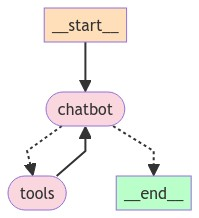

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Process and View Response

In [25]:
import pprint
from typing import List, Dict
from langchain_core.messages import BaseMessage, AIMessage, ToolMessage, HumanMessage

events = graph.stream(
  {"messages": [HumanMessage(content="Build a team to make an iOS app, and tell me the talent gaps")]},
  {"recursion_limit": 15},
)

def process_event(event: Dict) -> List[BaseMessage]:
  new_messages = []
  for value in event.values():
    if isinstance(value, dict) and 'messages' in value:
      for msg in value['messages']:
        if isinstance(msg, BaseMessage):
          new_messages.append(msg)
        elif isinstance(msg, dict) and 'content' in msg:
          new_messages.append(AIMessage(content=msg['content'], additional_kwargs={'sender': msg.get('sender')}))
        elif isinstance(msg, str):
          new_messages.append(ToolMessage(content=msg))
  return new_messages

for event in events:
  print("Event:")
  pprint.pprint(event)
  print("---")

  new_messages = process_event(event)
  if new_messages:
    temp_mem.add_messages(new_messages)

print("\nFinal state of temp_mem:")
if hasattr(temp_mem, 'messages'):
  for msg in temp_mem.messages:
    print(f"Type: {msg.__class__.__name__}")
    print(f"Content: {msg.content}")
    if msg.additional_kwargs:
      print("Additional kwargs:")
      pprint.pprint(msg.additional_kwargs)
    print("---")
else:
   print("temp_mem does not have a 'messages' attribute")

Event:
{'chatbot': {'messages': [AIMessage(content=[{'text': "Okay, let's try to build a team for making an iOS app and identify any talent gaps using the available tool.", 'type': 'text'}, {'id': 'toolu_0147LfjatFSoWVRFMHvvM6hV', 'input': {'query': 'iOS developer'}, 'name': 'lookup_employees', 'type': 'tool_use'}], response_metadata={'id': 'msg_01RSojaNUypEmcN7YYS5WxsL', 'model': 'claude-3-sonnet-20240229', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 381, 'output_tokens': 79}}, name='HR Chatbot', id='run-6ef23f8f-9777-4e58-a13b-16c3fddd6ffb-0', tool_calls=[{'name': 'lookup_employees', 'args': {'query': 'iOS developer'}, 'id': 'toolu_0147LfjatFSoWVRFMHvvM6hV'}], usage_metadata={'input_tokens': 381, 'output_tokens': 79, 'total_tokens': 460})],
             'sender': 'HR Chatbot'}}
---
Event:
{'tools': {'messages': [ToolMessage(content="[(Document(metadata={'_id': {'$oid': '66869852751d346e9874bba3'}, 'employee_id': 'E123457', 'first_name': 'Jane', 'last_n